<a href="https://colab.research.google.com/github/RuthKassahun/Breast-Cancer-Histopathy-Image-Classification/blob/main/Breast_Histopathology_Classigfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image, ImageOps
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from skimage.feature import local_binary_pattern

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [15]:
image_dir="/content/drive/MyDrive/BreakHis_Splitted"

In [16]:
# let's load our google drive
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
# Define the root data directory
DATA_DIR = "/content/drive/MyDrive/BreakHis_Splitted"

!ls $DATA_DIR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
test  train


### **Local Binary Patterns**

In [17]:
def compute_lbp(arr):
  """ Find LBP of all pixels.
  Also perform vectorization/normalization to get feature vector
  """
  # LBP function params
  radius = 3
  n_points = 8 * radius
  n_bins = n_points + 2
  lbp = local_binary_pattern(arr,n_points,radius,'uniform')
  lbp = lbp.ravel()
  #feature_len = int (lbp.max() + 1)
  feature = np.zeros(n_bins)
  for i in lbp:
    feature[int(i)] += 1 # Feature
  feature /= np.linalg.norm(feature, ord=1) # Normalizing feature
  return feature

### **Checking File Structure**

In [18]:
tag = 'train'
tag_dir = os.path.join(DATA_DIR, tag) # string
tag_dir

'/content/drive/MyDrive/BreakHis_Splitted/train'

In [19]:
tag_path = Path(tag_dir)
for cat_dir in tag_path.iterdir():
    cat_label = cat_dir.stem
    print(cat_label)
    sub_dir = os.path.join(tag_dir,cat_label)
    print(sub_dir)
    sub_path = Path(sub_dir)
    for inner_dir in sub_path.iterdir():
      inner_label = inner_dir.stem
      print(inner_label)

malignant
/content/drive/MyDrive/BreakHis_Splitted/train/malignant
papillary_carcinoma
ductal_carcinoma
lobular_carcinoma
mucinous_carcinoma
benign
/content/drive/MyDrive/BreakHis_Splitted/train/benign
tubular_adenoma
phyllodes_tumor
adenosis
fibroadenoma


### **Load Data**

In [20]:
def load_data(tag='train'):
  tag_dir = os.path.join(image_dir, tag)
  tag_path = Path(tag_dir)
  vec = [] # Vector
  cat = [] # Category
  for cat_dir in tag_path.iterdir():  
    cat_label = cat_dir.stem
    print("*",cat_label)
    for inner_dir in cat_dir.iterdir():
      inner_label = inner_dir.stem
      print(inner_label)
      for img_path in inner_dir.glob('*.png'):
        img = Image.open(img_path.as_posix()) #as_posix returns literally the absolute path
        if img.mode != 'L':
          img = ImageOps.grayscale(img)
          #img.save(img_path.as_posix()) # save it
        arr = np.array(img) # convert the image to numpy array
        feature = compute_lbp(arr)
        vec.append(feature) # append the feature to the data
        cat.append(cat_label) # append the label to the category
  return vec, cat # return lbp data and category

In [21]:
# train images
vec_train, cat_train = load_data('train')
# test images
vec_test, cat_test   = load_data('test')

* malignant
papillary_carcinoma
ductal_carcinoma
lobular_carcinoma
mucinous_carcinoma
* benign
tubular_adenoma
phyllodes_tumor
adenosis
fibroadenoma
* malignant
papillary_carcinoma
mucinous_carcinoma
ductal_carcinoma
lobular_carcinoma
* benign
phyllodes_tumor
tubular_adenoma
adenosis
fibroadenoma


### **List the Categories**

In [22]:
# Get unique categories
labels = list(np.unique(np.array(cat_train))) # convert categories to the numpy array and get unique values
labels

['benign', 'malignant']

In [23]:
labels = list(np.unique(np.array(cat_test))) # convert categories to the numpy array and get unique values
labels

['benign', 'malignant']

### **Label Encoding**

In [24]:
le = LabelEncoder()
label_train = le.fit_transform(cat_train) # Here fit is used to assign may be 0, 1, or 2
label_test = le.transform(cat_test) # Only transform is used since the fit is already done above

In [25]:
label_train

array([1, 1, 1, ..., 0, 0, 0])

In [26]:
label_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### **SVM Fit**

In [27]:
clf = LinearSVC(random_state=0, tol=1e-5) #Linear svm with tolerance of 1e-5
clf.fit(vec_train, label_train) # Features and labels

LinearSVC(random_state=0, tol=1e-05)

### **Evaluation**

Accuracy: 71.59%


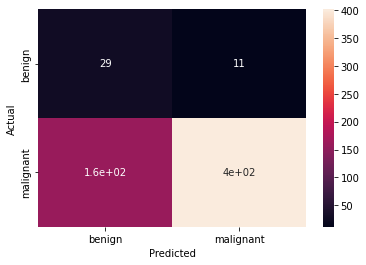

In [28]:
# Test set evaluation
prediction = clf.predict(vec_test)
# Visualization
cmat = metrics.confusion_matrix(prediction,label_test)
s = sns.heatmap(cmat,annot=True,xticklabels=labels, yticklabels=labels)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))